In [ ]:
import torch
import torchvision
import os
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torchvision.transforms as tt

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

1- Data normalization

2- Data Augmentation

3- Residual clipping 

4- Batch normalization

5- Learning Rate Shceduling 

6- weight Decay

7- Gradient clipping 

8- Adam optimizer

In [ ]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/cifar10'
print(os.listdir(data_dir))
classes = os.listdir(data_dir+'/train')
print(classes)

['test', 'train']
['horse', 'dog', 'frog', 'ship', 'cat', 'airplane', 'truck', 'automobile', 'deer', 'bird']


We can create training and validation datasets using the ImageFolder class from torchvision. In addition to the ToTensor transform, we'll also apply some other transforms to the images. There are a few important changes we'll make while creating pytorch datasets for training and validation.

1- Use test set for validation - Instead of setting aside a fraction of the data from the training set for validation, we'll simply use the test as our validation set. This just gives  a little more data to train with. In general, once you have picked the best model architecture and hyperparameters using a fixed validation set, it is good idea to retrain the same model on the entire dataset just to give it a small final boost performance.

2- channel-wise data normalization - We will normalize the image tensors by subracting the mean and dividing by the standard deviation across each channel. As a result, the mean of the data across each channel is 0, and standard deviation 1. Normalizing the data prevents the values from any one channel from disproportionately affecting the losses and gradients while training, simply by having  a higher or wider range of values that others.

3- Randomized data augmentation - We will apply random chosen transformation while loading images from the training dataset. Specifically, we will pad each image by 4 pixels, and then take a random crop of size 32x32 pixels, and then flip the image horizontally with a 50% probability. Since the transformation will be applied randomly and dynamically each time a particular image is loaded, the model sees slightly different images in each epoch of training, which allows it generalize better.

In [ ]:
# stats - mean and standard deviation across all images across all pixels
stats = ((0.4914,0.4822,0.4465),(0.2023,0.1994,0.2010))
train_transformations = tt.Compose([tt.RandomCrop(32,padding=4,padding_mode='reflect'),
                              tt.RandomHorizontalFlip(),
                              tt.RandomRotation(10),
                              tt.RandomResizedCrop(256,scale=(0.5,0.9),ratio=(1,1)),
                              tt.ColorJitter(brightness=0.1,contrast=0.1,saturation=0.1),
                              tt.ToTensor(),
                              tt.Normalize(*stats,inplace=True)
                              ])
valid_transformations = tt.Compose([tt.ToTensor(),tt.Normalize(*stats)])   # cannot transform in validation set

In [ ]:
# pytorch datasets
train_ds = ImageFolder(data_dir+'/train',train_transformations)
valid_ds = ImageFolder(data_dir+'/test',valid_transformations)

Now we can create data loaders for retrieving images in batches. we'll use a relatively large batch size of 400 to utilize a larger portion of the GPU RAM, 

In [ ]:
batch_size=64
# data laoders
train_dl = DataLoader(train_ds,batch_size,shuffle=True,num_workers=3,pin_memory=True)
valid_dl = DataLoader(valid_ds,batch_size*2,num_workers=3,pin_memory=True)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


To display the images, we'll need to denormalize the pixels values to bring them back into the range(0,1)

In [ ]:
def denormalize(images,means,stds):             # undoing the normalization
  means = torch.tensor(means).reshape(1,3,1,1)
  stds = torch.tensor(stds).reshape(1,3,1,1)
  return images*stds + means

def show_batch(dl):
  for images,labels in dl:
    fig,ax = plt.subplots(figsize=(12,12))
    ax.set_xticks([]); ax.set_yticks([])
    denorm_images = denormalize(images,*stats)
    ax.imshow(make_grid(denorm_images[:64],nrow=8).permute(1,2,0).clamp(0,1))
    break

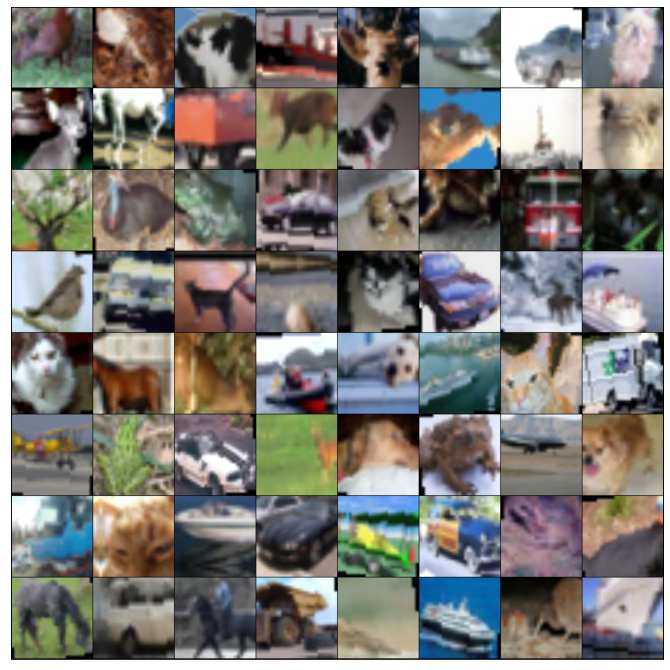

In [ ]:
show_batch(train_dl)

In [ ]:
def get_default_device():
  """Pick GPU if available else CPU"""
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data,device):
  """move tensor to the choosen device"""
  if isinstance(data,(list,tuple)):
    return [to_device(x,device) for x in data]
  return data.to(device,non_blocking=True)

class DeviceDataLoader():
  """wrap a dataloader to move data to a device"""
  def __init__(self,dl,device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    """Yeild a batch of data after moving it to device"""
    for b in self.dl:
      yield to_device(b,self.device)              # yield keyword in python is used to create a generator function that can be used within  a for loop
  
  def __len__(self):
    """Number of batches"""
    return len(self.dl)

device = get_default_device()
print(device)
# we can now wrap our data loaders using DeviceDataLoader
train_dl = DeviceDataLoader(train_dl,device)
val_dl = DeviceDataLoader(valid_dl,device) 
# Shifting model on GPU

cuda


Model with residual blocks and batch normalization

**While training ResNets, we either train the layers in residual blocks or skip the training for those layers using skip connections. So, different parts of networks will be trained at different rates for different training data points based on how the error flows backward in the network. This can be thought of as training an ensemble of different models on the dataset and getting the best possible accuracy.**

**Skipping training in some residual block layers can be looked at from an optimistic point of view too. In general, we do not know the optimal number of layers (or residual blocks) required for a neural network which might depend on the complexity of the dataset. Instead of treating the number of layers as an important hyperparameter to tune, by adding skip connections to our network, we are allowing the network to skip training for the layers that are not useful and do not add value in overall accuracy. In a way, skip connections make our neural networks dynamic to tune the number of layers during training optimally.**

In residual blocks we cannot change the number of ouput channel because we have to match output and input i.e g(out + x) to make it compatible for the tensor operation

In [ ]:
class SimpleResidualBlock(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=3,out_channels=3,kernel_size=3,stride=1,padding=1)
    self.relu1 = nn.ReLU()
    self.conv2 = nn.Conv2d(in_channels=3,out_channels=3,kernel_size=3,stride=1,padding=1)
    self.relu2 = nn.ReLU()

  def forward(self,x):    # x - (400,3,32,32)
    out = self.conv1(x)    # (400,3,32,32)
    out = self.relu1(out)   # (400,3,32,32)
    out = self.conv2(out)   # (400,3,32,32)
    out = self.relu2(out+x)   # (400,3,32,32) + (400,3,32,32)
    return out

In [ ]:
simple_resnet = to_device(SimpleResidualBlock(),device)
for images,label in train_dl:
  print('input shape:',images.shape)
  out = simple_resnet(images)
  print('output shape:',out.shape)
  break

input shape: torch.Size([64, 3, 256, 256])
output shape: torch.Size([64, 3, 256, 256])


This seemingly small change produces a drastic improvement in the performance of the model. Also, after convolution layer, we'll add a **batch normalization layer**, which normalizes the outputs of the previous layer.

batch normalization layer normalizes the output of the previous layer so that all the channels have the similar distribution.

Resnet9 

In [ ]:
def accuracy(outputs,labels):
  _,preds = torch.max(outputs,dim=1)
  return torch.tensor(torch.sum(preds == labels).item()/len(preds))

class ImageClassificationBase(nn.Module):
  def training_step(self,batch):
    images,labels = batch
    out = self(images)
    loss = F.cross_entropy(out,labels)
    return loss
  
  def validation_step(self,batch):
    images,labels = batch
    out = self(images)
    loss = F.cross_entropy(out,labels)
    acc = accuracy(out,labels)
    return {'val_loss':loss.detach(),'val_acc':acc}
  
  def validation_epoch_end(self,outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()
    return {'val_loss':epoch_loss.item(),'val_acc':epoch_acc.item()}
  
  def epoch_end(self,epoch,result):
    print("Epoch [{}] ,val_loss : {:.4f}, val_acc : {:.4f}".format(epoch,result['val_loss'],result['val_acc']))


def conv_block(in_channels,out_channels,pool=False):           
  layers = [nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1),      # layer containing conv, batch_normalization, activation fn and pooling layer if true 
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)]
  if pool : layers.append(nn.MaxPool2d(2))
  return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
  def __init__(self,in_channels,num_classes):
    super().__init__()                              # input - 3,256,256
    self.conv1 = conv_block(in_channels,64)         # out1 - 
    self.conv2 = conv_block(64,128,pool=True)
    self.res1 = nn.Sequential(conv_block(128,128),conv_block(128,128))     # residual layers having same inputs as outputs
    
    self.conv3 = conv_block(128,256,pool=True)
    self.conv4 = conv_block(256,512,pool=True)
    self.res2 = nn.Sequential(conv_block(512,512),conv_block(512,512))  # residual layers having same inputs as outputs
    
    self.classifier = nn.Sequential(nn.MaxPool2d(4),     #Dense Network   
                                    nn.Flatten(),
                                    nn.Dropout(0.2),
                                    nn.Linear(512,num_classes))
  def forward(self,xb):
    out = self.conv1(xb)
    #print('conv1 output:', out.shape)
    out = self.conv2(out)
    #print('conv2 output:', out.shape)
    out = self.res1(out) + out
    #print('res1 output:',out.shape)
    out = self.conv3(out)
    #print('conv3 output:',out.shape)
    out = self.conv4(out)
    #print('conv4 output:',out.shape)
    out = self.res2(out) + out 
    #print('res2 output:',out.shape)
    out = self.classifier(out)
    return out
  

In [ ]:
model = to_device(ResNet9(3,10),device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

Training the model -

improvements in training -

1- **Learning rate Scheduling** - Instead of using fixed learning rate, we will use a learning rate scheduler, which will change the learning after every batch of training. 
 https://sgugger.github.io/the-1cycle-policy.html

There are many strategies for varying the learning rate during training, and the one we'll use is called the "**One Cycle Learning Rate Policy**", which involves starting with a low learning rate, gradually increasing it batch-by-batch to a high learning rate for about 30% of epochs, then gradually decreasing it to very low value for the remaining epochs.

2- **Weight Decay** - We also use weight decay, which is yet another regularization technique which prevents the weights from becoming too large by adding an additional term to the loss function.
 https://towardsdatascience.com/this-thing-called-weight-decay-a7cd4bcfccab

3- **Gradient Clipping** - limiting the values of the gradients to a small range to prevent undesirable changes in parameters due to large gradients.

Defining fit one cycle function to incorporate these changes

In [ ]:
def evaluate(model,val_loader):
  model.eval()
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

def get_lr(optimizer):
  for param_group in optimizer.para_groups:
    return param_group['lr']


def fit_one_cycle(epochs,max_lr,model,train_loader,val_loader,weight_decay=0,grad_clip=None,opt_func=torch.optim.SGD):
  torch.cuda.empty_cache()
  history=[]
  # set up custom optimizer with weight decay
  optimizer = opt_func(model.parameters(),max_lr,weight_decay=weight_decay)
  # set up one cycle learning rate scheduler
  sched = torch.optim.lr_scheduler.OneCycleLR(optimizer,max_lr,epochs=epochs,steps_per_epoch=len(train_loader))
  
  for epoch in range(epochs):
    # training_phase
    model.train()
    train_losses=[]
    lrs=[]
    for batch in train_loader:
      loss = model.training_step(batch)
      train_losses.append(loss)
      loss.backward()

      # gradient clipping
      if grad_clip:
        nn.utils.clip_grad_value(model.parameters(),grad_clip)
      
      optimizer.step()
      optimizer.zero_grad()

      # record and update learning rate
      lrs.append(get_lr(optimizer))
      sched.step()

    #validation step
    result = evaluate(model,val_loader)
    result['train_loss'] = torch.stack(train_losses).mean().item()
    result['lrs'] = lrs 
    model.epoch_end()
    history.append(result)
  return history

In [ ]:
history = [evaluate(model,val_dl)]
history

[{'val_loss': 2.3046953678131104, 'val_acc': 0.1285601258277893}]

In [ ]:
%%time
epochs = 8
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam     # Adam optimizer

CPU times: user 7 µs, sys: 3 µs, total: 10 µs
Wall time: 12.2 µs


In [ ]:
history+=[fit_one_cycle(epochs,max_lr,model,train_dl,valid_dl,grad_clip=grad_clip,weight_decay=weight_decay,opt_func=opt_func)]

OutOfMemoryError: ignored

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

In [ ]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

plot_lrs(history)

Testing with individual images

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_ds.classes[preds[0].item()]



In [ ]:
img, label = valid_ds[0]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

In [ ]:
img, label = valid_ds[1002]
plt.imshow(img.permute(1, 2, 0))
print('Label:', valid_ds.classes[label], ', Predicted:', predict_image(img, model))

In [ ]:
img, label = valid_ds[6153]
plt.imshow(img.permute(1, 2, 0))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))